# Filtering Streams
The following code illustrates how we can use hashes to test membership in a list.

In [1]:
import numpy as np

In [2]:
def my_hash(item, nbuckets):
    "Return a hash value between 0 and nbuckets - 1"
    return hash(item) % nbuckets

In [3]:
my_hash("Peter", 1000)

951

In [4]:
my_hash("Mary", 1000)

235

In [5]:
my_hash('Susan', 1000)

173

In [6]:
my_hash('John', 1000)

542

In [7]:
# Building the filter
NBUCKETS = 1000
S = ['John', 'Mary', 'Peter', 'Susan']
hash_filter = np.zeros(NBUCKETS, dtype=np.bool)
for s in S:
    hash_filter[my_hash(s, NBUCKETS)] = True

In [8]:
# Testing the filter
def in_filter(item):
    "Return True if the item is in the filter"
    return hash_filter[my_hash(item, NBUCKETS)]

In [9]:
in_filter("John")

True

In [10]:
in_filter("Diego")

False

## Bloom Filter
The following code implements a Bloom filter

In [11]:
my_hash(("John", 0), 1000)

821

In [12]:
my_hash(("John", 1), 1000)

346

In [13]:
# Building the filter
K = 5 # We use 5 independent hash functions
NBUCKETS = 1000
S = ['John', 'Mary', 'Peter', 'Susan']
hash_filter = np.zeros(NBUCKETS, dtype=np.bool)
for s in S:
    for k in range(K):
        hash_filter[my_hash((s, k), NBUCKETS)] = True

In [14]:
# Testing the filter
def in_filter(item):
    "Return True if the item is in the filter"
    result = True
    for k in range(K):
        result = result and hash_filter[my_hash((item, k), NBUCKETS)]
    return result

In [15]:
in_filter('John')

True

In [16]:
in_filter('Diego')

False

# The Flajolet-Martin Algorithm
The following algorithm estimates the count of distinct items.

In [17]:
NBUCKETS = 2**32
def tail_length(item):
    "Return the tail length of the hash of the item"
    s = bin(hash(item) % NBUCKETS)
    return len(s) - len(s.rstrip('0'))

In [18]:
print(bin(hash("Phillip") % NBUCKETS))
print(tail_length("Phillip"))

0b10011011001001010001101000000110
1


In [19]:
2**32

4294967296

With one hash function

In [20]:
def count_distinct(stream):
    maxR = 0
    for s in stream:
        r = tail_length(s)
        if r > maxR:
            maxR = r
    return 2**maxR

Let's estimate the number of distinct words in the Brown corpus

In [21]:
import nltk
nltk.download('brown')
words = nltk.corpus.brown.words()
len(words)

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Unzipping corpora/brown.zip.


1161192

In [22]:
count_distinct(words[:10000])

4096

Compare with a brute force exact count:

In [23]:
len(set(words[:10000]))

2690

Variant using multiple hash functions

In [24]:
%matplotlib inline
from matplotlib import pyplot as plt

K = 256 # number of distinct hashes
G = 16  # size of each group of hashes
assert K % G == 0 # Check that K is divisible by G

def count_distinct(stream):
    maxR = np.zeros(K) # Initialise all R for all hashes to zero 
    
    # 1. Compute R for each hash
    print("Step 1")
    for s in stream:
        for h in range(K):
            r = tail_length((s, h))
            if r > maxR[h]:
                maxR[h] = r
                
    plt.hist(maxR)
                
    # 2. Combine all R
    print("Step 2")
    Counts = []
    for group in range(K//G):
        groupCounts = []
        for h in range(G):
            groupCounts.append(2**maxR[group*G + h])
        Counts.append(np.median(groupCounts))
    return(np.mean(Counts))

Step 1
Step 2


2752.0

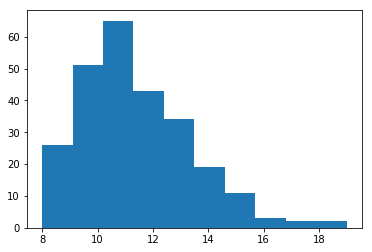

In [25]:
count_distinct(words[:10000])

In [26]:
np.mean([1,2,3,4,10])

4.0

In [27]:
np.median([1,2,3,4,10])

3.0

## More Streams
The following code shows some simple processing of streams by answering some of the questions from the lectures -- week 8, page 4. The queries are related to a stream of recordings from a temperature sensor.

### Alert when the temperature exceeds 25 degrees
This is a very simple case that does not need to keep any working storage.

In [28]:
class ProcessStream:
    def step(self, s):
        if s >= 25:
            print("Alert: Temperature is %f" % s)          

Below is an example of the stream at work with some simulated data. The data have been obtained from http://www.bom.gov.au/climate/data/

In [29]:
import csv
def temperature_sensor():
    with open('temperature_sensor/IDCJAC0010_066062_1800_Data.csv') as f:
        reader = csv.DictReader(f)
        for line in reader:
            yield float(line['Maximum temperature (Degree C)'])

In [30]:
t = temperature_sensor()
stream_processor = ProcessStream()
for i in range(100):
    stream_processor.step(next(t))

Alert: Temperature is 25.100000
Alert: Temperature is 33.900000
Alert: Temperature is 27.200000
Alert: Temperature is 28.600000
Alert: Temperature is 27.300000
Alert: Temperature is 25.400000
Alert: Temperature is 33.100000
Alert: Temperature is 36.900000
Alert: Temperature is 25.800000
Alert: Temperature is 26.900000
Alert: Temperature is 25.600000
Alert: Temperature is 25.900000
Alert: Temperature is 25.600000
Alert: Temperature is 25.000000
Alert: Temperature is 26.900000
Alert: Temperature is 27.200000
Alert: Temperature is 35.600000
Alert: Temperature is 32.300000
Alert: Temperature is 26.800000
Alert: Temperature is 26.200000
Alert: Temperature is 32.800000
Alert: Temperature is 28.600000
Alert: Temperature is 25.400000
Alert: Temperature is 26.500000
Alert: Temperature is 25.900000
Alert: Temperature is 25.000000
Alert: Temperature is 26.700000
Alert: Temperature is 25.000000
Alert: Temperature is 28.200000
Alert: Temperature is 25.300000
Alert: Temperature is 25.000000
Alert: T

### Average the 24 most recent readings
The working storage will need to keep track of the 24 most recent readings. When a new reading comes, the last reading will need to be dropped from the list.

In [31]:
import numpy as np
class ProcessStream():
    past_readings = []
    def step(self, s):
        if len(self.past_readings) >= 24:
            self.past_readings = self.past_readings[1:]
        self.past_readings.append(s)
        return(np.mean(self.past_readings))    

In [32]:
t = temperature_sensor()
stream_processor = ProcessStream()
for i in range(100):
    avg = stream_processor.step(next(t))
    print("Average: %f" % avg)

Average: 24.400000
Average: 24.400000
Average: 24.333333
Average: 24.425000
Average: 24.460000
Average: 24.083333
Average: 24.171429
Average: 24.287500
Average: 25.355556
Average: 25.540000
Average: 25.818182
Average: 25.941667
Average: 25.800000
Average: 25.771429
Average: 25.640000
Average: 25.562500
Average: 26.005882
Average: 26.611111
Average: 26.568421
Average: 26.410000
Average: 26.285714
Average: 26.154545
Average: 26.186957
Average: 26.162500
Average: 26.170833
Average: 26.187500
Average: 26.216667
Average: 26.266667
Average: 26.308333
Average: 26.316667
Average: 26.145833
Average: 26.029167
Average: 25.562500
Average: 25.400000
Average: 25.250000
Average: 25.233333
Average: 25.362500
Average: 25.787500
Average: 26.141667
Average: 26.241667
Average: 25.954167
Average: 25.412500
Average: 25.704167
Average: 25.920833
Average: 25.987500
Average: 26.116667
Average: 25.925000
Average: 25.708333
Average: 25.512500
Average: 25.450000
Average: 25.433333
Average: 25.337500
Average: 25.

### Average temperature from the beginning of the stream
We cannot store all past records since the size of the stream is potentially infinite. But we can keep the sum and count in working storage and with this information compute the average.

In [33]:
class ProcessStream():
    past_sum = 0
    past_count = 0
    def step(self, s):
        self.past_sum += s
        self.past_count += 1
        return(self.past_sum / self.past_count)

In [34]:
t = temperature_sensor()
stream_processor = ProcessStream()
for i in range(100):
    avg = stream_processor.step(next(t))
    print("Average: %f" % avg)

Average: 24.400000
Average: 24.400000
Average: 24.333333
Average: 24.425000
Average: 24.460000
Average: 24.083333
Average: 24.171429
Average: 24.287500
Average: 25.355556
Average: 25.540000
Average: 25.818182
Average: 25.941667
Average: 25.800000
Average: 25.771429
Average: 25.640000
Average: 25.562500
Average: 26.005882
Average: 26.611111
Average: 26.568421
Average: 26.410000
Average: 26.285714
Average: 26.154545
Average: 26.186957
Average: 26.162500
Average: 26.100000
Average: 26.050000
Average: 26.007407
Average: 26.003571
Average: 25.989655
Average: 25.870000
Average: 25.700000
Average: 25.593750
Average: 25.506061
Average: 25.441176
Average: 25.428571
Average: 25.469444
Average: 25.516216
Average: 25.781579
Average: 25.948718
Average: 25.970000
Average: 25.975610
Average: 25.926190
Average: 26.086047
Average: 26.143182
Average: 26.126667
Average: 26.134783
Average: 26.053191
Average: 25.935417
Average: 25.812245
Average: 25.762000
Average: 25.737255
Average: 25.696154
Average: 25.